In [1]:
import os
import sys
import json
import math
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

import numpy as np
import pandas as pd

# Stats
from scipy.stats import chi2_contingency

# Plotting
import matplotlib.pyplot as plt

# -------------------------
# Robust PROJECT_ROOT detection
# -------------------------
def find_project_root(start: Optional[Path] = None) -> Path:
    start = Path.cwd() if start is None else Path(start)
    cur = start.resolve()
    if (cur / "requirements.txt").exists() or (cur / ".git").exists():
        return cur
    for parent in cur.parents:
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            return parent
    return cur  # fallback

PROJECT_ROOT = find_project_root()
print("PROJECT_ROOT =", PROJECT_ROOT)

# Allow imports like: from utils.dataio import ...
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# Canonical directories
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed" / "hapmap"
DERIVED_DIR = DATA_DIR / "derived" / "method1"

REGIONS_DIR = PROCESSED_DIR / "regions"
COHORTS_PATH = PROCESSED_DIR / "cohorts" / "hapmap_CEU_control_test__YRI_case.json"

RESULTS_DIR = PROJECT_ROOT / "results"
FIG_DIR = RESULTS_DIR / "figures" / "method1"
TABLE_DIR = RESULTS_DIR / "tables" / "method1"

for d in [DERIVED_DIR, FIG_DIR, TABLE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("REGIONS_DIR:", REGIONS_DIR)
print("COHORTS_PATH exists?", COHORTS_PATH.exists())
print("DERIVED_DIR:", DERIVED_DIR)
print("FIG_DIR:", FIG_DIR)
print("TABLE_DIR:", TABLE_DIR)


PROJECT_ROOT = /Users/erkmenerken/Desktop/proje430
REGIONS_DIR: /Users/erkmenerken/Desktop/proje430/data/processed/hapmap/regions
COHORTS_PATH exists? True
DERIVED_DIR: /Users/erkmenerken/Desktop/proje430/data/derived/method1
FIG_DIR: /Users/erkmenerken/Desktop/proje430/results/figures/method1
TABLE_DIR: /Users/erkmenerken/Desktop/proje430/results/tables/method1


In [2]:
import json
import numpy as np
from pathlib import Path

# ---- Robust PROJECT_ROOT ----
def find_project_root(start=None):
    p = Path(start or Path.cwd()).resolve()
    for parent in [p] + list(p.parents):
        if (parent / ".git").exists() or (parent / "requirements.txt").exists():
            return parent
    return p

PROJECT_ROOT = find_project_root()
PROC_DIR = PROJECT_ROOT / "data" / "processed" / "hapmap"
REGION_DIR = PROC_DIR / "regions"
COHORT_DIR = PROC_DIR / "cohorts"
COHORTS_JSON = COHORT_DIR / "hapmap_CEU_control_test__YRI_case.json"

REGION_CHR2 = REGION_DIR / "CEU_chr2_5Mb.common_with_YRI.npz"
REGION_CHR10 = REGION_DIR / "CEU_chr10_1Mb.common_with_YRI.npz"

for p in [REGION_CHR2, REGION_CHR10, COHORTS_JSON]:
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")

print(" Loading region NPZ files + cohort split JSON from disk...")

# ---- Load region data (disk-backed; no in-memory dependencies) ----
r2 = np.load(REGION_CHR2, allow_pickle=True)
r10 = np.load(REGION_CHR10, allow_pickle=True)

G2 = r2["G"].astype(np.int8)
rs2 = np.array(r2["snp_ids"], dtype=object)
pos2 = np.array(r2["positions"], dtype=np.int32)
ids2 = np.array([str(x) for x in r2["sample_ids"]], dtype=object)

G10 = r10["G"].astype(np.int8)
rs10 = np.array(r10["snp_ids"], dtype=object)
pos10 = np.array(r10["positions"], dtype=np.int32)
ids10 = np.array([str(x) for x in r10["sample_ids"]], dtype=object)

# ---- Load cohorts (case/control/test) ----
cohorts = json.loads(COHORTS_JSON.read_text())
control_ids = set(map(str, cohorts["control"]["sample_ids"]))
test_ids = set(map(str, cohorts["test"]["sample_ids"]))

def indices_from_ids(all_ids, wanted_ids_set):
    mask = np.array([i in wanted_ids_set for i in all_ids], dtype=bool)
    return np.where(mask)[0]

control_idx2 = indices_from_ids(ids2, control_ids)
test_idx2    = indices_from_ids(ids2, test_ids)

control_idx10 = indices_from_ids(ids10, control_ids)
test_idx10    = indices_from_ids(ids10, test_ids)

print(f"chr2 : control n={len(control_idx2)} | test n={len(test_idx2)}")
print(f"chr10: control n={len(control_idx10)} | test n={len(test_idx10)}")

if len(control_idx2) == 0 or len(test_idx2) == 0:
    raise RuntimeError("chr2 cohort mapping failed: no matched control/test IDs in chr2 region sample_ids.")
if len(control_idx10) == 0 or len(test_idx10) == 0:
    raise RuntimeError("chr10 cohort mapping failed: no matched control/test IDs in chr10 region sample_ids.")

def maf_from_G(G_sub):
    # minor allele frequency from minor-allele counts {0,1,2}, missing=-1
    mask = (G_sub >= 0)
    col_sum = (G_sub * mask).sum(axis=0).astype(np.float64)
    col_n = mask.sum(axis=0).astype(np.float64)

    maf = np.full(G_sub.shape[1], np.nan, dtype=np.float64)
    ok = col_n > 0
    maf[ok] = (col_sum[ok] / col_n[ok]) / 2.0
    return maf

maf_ctrl_chr2 = maf_from_G(G2[control_idx2])
maf_test_chr2 = maf_from_G(G2[test_idx2])

maf_ctrl_chr10 = maf_from_G(G10[control_idx10])
maf_test_chr10 = maf_from_G(G10[test_idx10])

freq_out = PROC_DIR / "ceu_maf_reference.npz"
np.savez_compressed(
    freq_out,
    chr2_control_maf=maf_ctrl_chr2,
    chr2_test_maf=maf_test_chr2,
    chr2_snp_ids=rs2,
    chr2_positions=pos2,
    chr10_control_maf=maf_ctrl_chr10,
    chr10_test_maf=maf_test_chr10,
    chr10_snp_ids=rs10,
    chr10_positions=pos10,
)

print(" Computed and saved CEU MAF references (control + test)")
print(" Saved:", freq_out.relative_to(PROJECT_ROOT))
print("   chr2 mean control MAF =", float(np.nanmean(maf_ctrl_chr2)))
print("   chr10 mean control MAF =", float(np.nanmean(maf_ctrl_chr10)))

 Loading region NPZ files + cohort split JSON from disk...
chr2 : control n=120 | test n=54
chr10: control n=120 | test n=54
 Computed and saved CEU MAF references (control + test)
 Saved: data/processed/hapmap/ceu_maf_reference.npz
   chr2 mean control MAF = 0.4915183711612868
   chr10 mean control MAF = 0.4902755962014695


In [3]:
import json
import numpy as np
from pathlib import Path

# ---- Robust PROJECT_ROOT ----
def find_project_root(start=None):
    p = Path(start or Path.cwd()).resolve()
    for parent in [p] + list(p.parents):
        if (parent / ".git").exists() or (parent / "requirements.txt").exists():
            return parent
    return p

PROJECT_ROOT = find_project_root()
PROC_DIR = PROJECT_ROOT / "data" / "processed" / "hapmap"
REGION_DIR = PROC_DIR / "regions"
COHORT_DIR = PROC_DIR / "cohorts"
COHORTS_JSON = COHORT_DIR / "hapmap_CEU_control_test__YRI_case.json"

REGION_CHR2 = REGION_DIR / "CEU_chr2_5Mb.common_with_YRI.npz"
REGION_CHR10 = REGION_DIR / "CEU_chr10_1Mb.common_with_YRI.npz"

for p in [REGION_CHR2, REGION_CHR10, COHORTS_JSON]:
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")

print(" Loading region NPZ files + cohort split JSON from disk...")

# ---- Load region data (disk-backed; no in-memory dependencies) ----
r2 = np.load(REGION_CHR2, allow_pickle=True)
r10 = np.load(REGION_CHR10, allow_pickle=True)

G2 = r2["G"].astype(np.int8)
rs2 = np.array(r2["snp_ids"], dtype=object)
pos2 = np.array(r2["positions"], dtype=np.int32)
ids2 = np.array([str(x) for x in r2["sample_ids"]], dtype=object)

G10 = r10["G"].astype(np.int8)
rs10 = np.array(r10["snp_ids"], dtype=object)
pos10 = np.array(r10["positions"], dtype=np.int32)
ids10 = np.array([str(x) for x in r10["sample_ids"]], dtype=object)

# ---- Load cohorts (case/control/test) ----
cohorts = json.loads(COHORTS_JSON.read_text())
control_ids = set(map(str, cohorts["control"]["sample_ids"]))
test_ids = set(map(str, cohorts["test"]["sample_ids"]))

def indices_from_ids(all_ids, wanted_ids_set):
    mask = np.array([i in wanted_ids_set for i in all_ids], dtype=bool)
    return np.where(mask)[0]

control_idx2 = indices_from_ids(ids2, control_ids)
test_idx2    = indices_from_ids(ids2, test_ids)

control_idx10 = indices_from_ids(ids10, control_ids)
test_idx10    = indices_from_ids(ids10, test_ids)

print(f"chr2 : control n={len(control_idx2)} | test n={len(test_idx2)}")
print(f"chr10: control n={len(control_idx10)} | test n={len(test_idx10)}")

if len(control_idx2) == 0 or len(test_idx2) == 0:
    raise RuntimeError("chr2 cohort mapping failed: no matched control/test IDs in chr2 region sample_ids.")
if len(control_idx10) == 0 or len(test_idx10) == 0:
    raise RuntimeError("chr10 cohort mapping failed: no matched control/test IDs in chr10 region sample_ids.")

def maf_from_G(G_sub):
    # minor allele frequency from minor-allele counts {0,1,2}, missing=-1
    mask = (G_sub >= 0)
    col_sum = (G_sub * mask).sum(axis=0).astype(np.float64)
    col_n = mask.sum(axis=0).astype(np.float64)

    maf = np.full(G_sub.shape[1], np.nan, dtype=np.float64)
    ok = col_n > 0
    maf[ok] = (col_sum[ok] / col_n[ok]) / 2.0
    return maf

maf_ctrl_chr2 = maf_from_G(G2[control_idx2])
maf_test_chr2 = maf_from_G(G2[test_idx2])

maf_ctrl_chr10 = maf_from_G(G10[control_idx10])
maf_test_chr10 = maf_from_G(G10[test_idx10])

freq_out = PROC_DIR / "ceu_maf_reference.npz"
np.savez_compressed(
    freq_out,
    chr2_control_maf=maf_ctrl_chr2,
    chr2_test_maf=maf_test_chr2,
    chr2_snp_ids=rs2,
    chr2_positions=pos2,
    chr10_control_maf=maf_ctrl_chr10,
    chr10_test_maf=maf_test_chr10,
    chr10_snp_ids=rs10,
    chr10_positions=pos10,
)

print(" Computed and saved CEU MAF references (control + test)")
print(" Saved:", freq_out.relative_to(PROJECT_ROOT))
print("   chr2 mean control MAF =", float(np.nanmean(maf_ctrl_chr2)))
print("   chr10 mean control MAF =", float(np.nanmean(maf_ctrl_chr10)))

 Loading region NPZ files + cohort split JSON from disk...
chr2 : control n=120 | test n=54
chr10: control n=120 | test n=54
 Computed and saved CEU MAF references (control + test)
 Saved: data/processed/hapmap/ceu_maf_reference.npz
   chr2 mean control MAF = 0.4915183711612868
   chr10 mean control MAF = 0.4902755962014695


In [4]:
# -------------------------
# Experiment configuration
# -------------------------
SEED = 0
rng = np.random.default_rng(SEED)

# epsilons to benchmark
EPS_LIST = [0.1, 0.3, 1.0, 3.0, 10.0]

# Sensitivity choice:
# - "proposal_vector": use Δ1 = 2N for the whole vector query (proposal wording)
# - "per_snp": use Δ1 = 2 for each SNP count (more standard per-coordinate sensitivity)
SENSITIVITY_MODE = "proposal_vector"   

# Utility: significance cutoff
PVALUE_CUTOFF = 1e-5

# LR score: numerical stability
P_CLIP = 1e-6

# For LR thresholding: choose threshold so that (1-alpha) quantile is cutoff (e.g. alpha=0.05)
ALPHA_TEST_EXCEED = 0.05

print("SEED =", SEED)
print("EPS_LIST =", EPS_LIST)
print("SENSITIVITY_MODE =", SENSITIVITY_MODE)
print("PVALUE_CUTOFF =", PVALUE_CUTOFF)
print("ALPHA_TEST_EXCEED =", ALPHA_TEST_EXCEED)

SEED = 0
EPS_LIST = [0.1, 0.3, 1.0, 3.0, 10.0]
SENSITIVITY_MODE = proposal_vector
PVALUE_CUTOFF = 1e-05
ALPHA_TEST_EXCEED = 0.05


In [5]:
def load_json(path: Path) -> dict:
    return json.loads(path.read_text())

cohorts = load_json(COHORTS_PATH)

# Expecting keys: cohorts["control"]["indices_in_ceu_matrix"], cohorts["test"]["indices_in_ceu_matrix"],
# and cohorts["case"]["indices_in_yri_matrix"]
for split in ["control", "test", "case"]:
    assert split in cohorts, f"Missing '{split}' in cohorts json"
assert "indices_in_ceu_matrix" in cohorts["control"], "Missing indices_in_ceu_matrix in control"
assert "indices_in_ceu_matrix" in cohorts["test"], "Missing indices_in_ceu_matrix in test"
assert "indices_in_yri_matrix" in cohorts["case"], "Missing indices_in_yri_matrix in case"
print("Loaded cohorts:", {
    "control": len(cohorts["control"]["indices_in_ceu_matrix"]),
    "test": len(cohorts["test"]["indices_in_ceu_matrix"]),
    "case": len(cohorts["case"]["indices_in_yri_matrix"]),
})

REGION_FILES_CEU = {
    "chr2_5Mb": REGIONS_DIR / "CEU_chr2_5Mb.common_with_YRI.npz",
    "chr10_1Mb": REGIONS_DIR / "CEU_chr10_1Mb.common_with_YRI.npz",
}
REGION_FILES_YRI = {
    "chr2_5Mb": REGIONS_DIR / "YRI_chr2_5Mb.common_with_CEU.npz",
    "chr10_1Mb": REGIONS_DIR / "YRI_chr10_1Mb.common_with_CEU.npz",
}

for name, path in REGION_FILES_CEU.items():
    if not path.exists():
        raise FileNotFoundError(f"Missing CEU region file: {path}")
for name, path in REGION_FILES_YRI.items():
    if not path.exists():
        raise FileNotFoundError(f"Missing YRI region file: {path}")

def load_region_npz(path: Path) -> dict:
    z = np.load(path, allow_pickle=True)
    d = {k: z[k] for k in z.files}
    return d

regions = {}
for region_tag in REGION_FILES_CEU:
    ceu = load_region_npz(REGION_FILES_CEU[region_tag])
    yri = load_region_npz(REGION_FILES_YRI[region_tag])

    # Sanity checks: aligned SNPs must match exactly
    assert np.array_equal(ceu["snp_ids"], yri["snp_ids"]), f"SNP IDs mismatch for {region_tag}"
    assert np.array_equal(ceu["positions"], yri["positions"]), f"Positions mismatch for {region_tag}"

    regions[region_tag] = {"ceu": ceu, "yri": yri}

# Quick key inspection
for name, d in regions.items():
    print("==", name, "==")
    print("CEU keys:", list(d["ceu"].keys())[:12])
    print("YRI keys:", list(d["yri"].keys())[:12])


Loaded cohorts: {'control': 120, 'test': 54, 'case': 176}
== chr2_5Mb ==
CEU keys: ['G', 'sample_ids', 'snp_ids', 'positions', 'counted_alleles', 'other_alleles', 'minor_alleles', 'major_alleles', 'chrom']
YRI keys: ['G', 'sample_ids', 'snp_ids', 'positions', 'counted_alleles', 'other_alleles', 'minor_alleles', 'major_alleles', 'chrom']
== chr10_1Mb ==
CEU keys: ['G', 'sample_ids', 'snp_ids', 'positions', 'counted_alleles', 'other_alleles', 'minor_alleles', 'major_alleles', 'chrom']
YRI keys: ['G', 'sample_ids', 'snp_ids', 'positions', 'counted_alleles', 'other_alleles', 'minor_alleles', 'major_alleles', 'chrom']


In [6]:
def _pick_genotype_matrix(region: dict) -> np.ndarray:
    """
    Try common keys first, otherwise guess the first 2D integer-like array.
    Expected shape: (n_snps, n_individuals) or (n_individuals, n_snps)
    """
    for key in ["G", "G_sub", "genotypes", "X"]:
        if key in region:
            G = region[key]
            if G.ndim == 2:
                return G
    # guess
    for k, v in region.items():
        if isinstance(v, np.ndarray) and v.ndim == 2:
            if np.issubdtype(v.dtype, np.integer) or v.dtype == np.float64:
                return v
    raise KeyError("Could not locate genotype matrix in region npz (expected key like 'G').")

def _ensure_snps_by_individuals(G: np.ndarray) -> np.ndarray:
    """
    We want shape (n_snps, n_individuals).
    If it looks like (n_individuals, n_snps), transpose.
    Heuristic: n_snps usually >> n_individuals.
    """
    if G.shape[0] < G.shape[1]:
        # likely individuals x snps -> transpose
        return G.T
    return G

def compute_counts_and_maf(G_snps_x_ind: np.ndarray, cols: List[int]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    G_snps_x_ind: (n_snps, n_indiv), dosage 0/1/2, missing=-1
    cols: which individuals to use
    Returns:
      called_n_per_snp (n_snps,)
      allele_count_per_snp (n_snps,)
      freq_per_snp (n_snps,)
    """
    sub = G_snps_x_ind[:, cols]  # (n_snps, n_cols)
    called = sub != -1
    called_n = called.sum(axis=1).astype(np.int32)

    # sum of dosages ignoring missing
    sub_nonmiss = np.where(called, sub, 0)
    mac = sub_nonmiss.sum(axis=1).astype(np.float64)  # counted-allele count (0..2*called_n)

    denom = 2.0 * np.maximum(called_n, 1)  # avoid div0
    maf = mac / denom
    return called_n, mac, maf

def laplace_mechanism_counts(mac: np.ndarray, n_snps: int, eps: float, rng: np.random.Generator,
                            sensitivity_mode: str = "proposal_vector") -> np.ndarray:
    """
    Add Laplace noise to each SNP allele count.
    mac: (n_snps,) true counts
    Returns noisy counts (float).
    """
    if eps <= 0:
        raise ValueError("epsilon must be > 0")

    if sensitivity_mode == "proposal_vector":
        # proposal: sensitivity for the WHOLE vector is 2N -> use as Laplace scale for each coordinate
        delta1 = 2.0 * float(n_snps)
    elif sensitivity_mode == "per_snp":
        # per coordinate change max 2 (one person changes up to 2 alleles at that SNP)
        delta1 = 2.0
    else:
        raise ValueError(f"Unknown sensitivity_mode={sensitivity_mode}")

    scale = delta1 / eps
    noise = rng.laplace(loc=0.0, scale=scale, size=mac.shape[0])
    return mac + noise

def postprocess_noisy_maf(noisy_mac: np.ndarray, called_n: np.ndarray) -> np.ndarray:
    """
    Convert noisy allele counts -> frequency, then clip to [0,1].
    """
    denom = 2.0 * np.maximum(called_n.astype(np.float64), 1.0)
    maf = noisy_mac / denom
    maf = np.clip(maf, 0.0, 1.0)
    return maf

def noisy_counts_from_maf(noisy_maf: np.ndarray, called_n: np.ndarray) -> np.ndarray:
    """
    Convert clipped noisy frequencies back to counts and clip to valid range.
    """
    counts = noisy_maf * (2.0 * called_n.astype(np.float64))
    max_counts = 2.0 * called_n.astype(np.float64)
    return np.clip(counts, 0.0, max_counts)

def genotype_log_prob_hwe(g: np.ndarray, p: np.ndarray) -> np.ndarray:
    """
    HWE genotype probabilities given allele frequency p.
    g: array of dosages 0/1/2 with possible -1 (missing)
    p: array of same length, clipped away from 0/1
    Returns log P(g | p) per SNP (missing -> 0 contribution).
    """
    p = np.clip(p, P_CLIP, 1.0 - P_CLIP)
    q = 1.0 - p

    # log probs per genotype
    logP0 = 2.0 * np.log(q)
    logP1 = np.log(2.0) + np.log(p) + np.log(q)
    logP2 = 2.0 * np.log(p)

    out = np.zeros_like(p, dtype=np.float64)
    out = np.where(g == 0, logP0, out)
    out = np.where(g == 1, logP1, out)
    out = np.where(g == 2, logP2, out)
    # missing -> 0
    return out

def lr_scores(G_snps_x_ind: np.ndarray, cols: List[int], p_case: np.ndarray, p_ctrl: np.ndarray) -> np.ndarray:
    """
    Compute LR score per individual:
      LR_i = sum_j log P(g_ij | p_case_j) - log P(g_ij | p_ctrl_j)
    Using HWE genotype likelihoods.
    """
    G = G_snps_x_ind[:, cols]  # (n_snps, n_ind)
    n_ind = G.shape[1]
    scores = np.zeros(n_ind, dtype=np.float64)

    for i in range(n_ind):
        g = G[:, i]
        # only non-missing SNPs contribute
        mask = g != -1
        if not np.any(mask):
            scores[i] = 0.0
            continue

        log_case = genotype_log_prob_hwe(g[mask], p_case[mask])
        log_ctrl = genotype_log_prob_hwe(g[mask], p_ctrl[mask])
        scores[i] = float(np.sum(log_case - log_ctrl))

    return scores

def chisq_pvalues_case_vs_control(mac_case: np.ndarray, called_case: np.ndarray,
                                 mac_ctrl: np.ndarray, called_ctrl: np.ndarray) -> np.ndarray:
    """
    Per SNP chi-square test on 2x2 allele table:
      case: [minor, major], control: [minor, major]
    Returns p-values per SNP.
    """
    n = mac_case.shape[0]
    pvals = np.ones(n, dtype=np.float64)

    for j in range(n):
        # allele counts
        minor_case = mac_case[j]
        major_case = 2.0 * called_case[j] - minor_case
        minor_ctrl = mac_ctrl[j]
        major_ctrl = 2.0 * called_ctrl[j] - minor_ctrl

        # skip if denom weird
        if called_case[j] <= 0 or called_ctrl[j] <= 0:
            pvals[j] = 1.0
            continue

        # ensure non-negative
        if major_case < 0 or major_ctrl < 0:
            pvals[j] = 1.0
            continue

        table = np.array([[minor_case, major_case],
                          [minor_ctrl, major_ctrl]], dtype=np.float64)

        # If any row sums to 0, chi-square is meaningless
        if np.any(table.sum(axis=1) <= 0) or np.any(table.sum(axis=0) <= 0):
            pvals[j] = 1.0
            continue

        # chi-square
        try:
            _, p, _, _ = chi2_contingency(table, correction=False)
            pvals[j] = float(p)
        except Exception:
            pvals[j] = 1.0

    return pvals

def overlap_metrics(sig_true: np.ndarray, sig_noisy: np.ndarray) -> Dict[str, float]:
    """
    sig_true/noisy are boolean arrays length n_snps.
    """
    a = sig_true.astype(bool)
    b = sig_noisy.astype(bool)
    tp = int(np.sum(a & b))
    fp = int(np.sum(~a & b))
    fn = int(np.sum(a & ~b))

    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    jaccard = tp / (tp + fp + fn) if (tp + fp + fn) else 0.0

    return {
        "true_sig": int(np.sum(a)),
        "noisy_sig": int(np.sum(b)),
        "tp": tp,
        "precision": float(precision),
        "recall": float(recall),
        "jaccard": float(jaccard),
    }


In [7]:
import json
import numpy as np
from pathlib import Path

# ---- Robust PROJECT_ROOT ----
def find_project_root(start=None):
    p = Path(start or Path.cwd()).resolve()
    for parent in [p] + list(p.parents):
        if (parent / ".git").exists() or (parent / "requirements.txt").exists():
            return parent
    return p

PROJECT_ROOT = find_project_root()
PROC_DIR = PROJECT_ROOT / "data" / "processed" / "hapmap"
REGION_DIR = PROC_DIR / "regions"
COHORT_DIR = PROC_DIR / "cohorts"
COHORTS_JSON = COHORT_DIR / "hapmap_CEU_control_test__YRI_case.json"

REGION_CHR2 = REGION_DIR / "CEU_chr2_5Mb.common_with_YRI.npz"
REGION_CHR10 = REGION_DIR / "CEU_chr10_1Mb.common_with_YRI.npz"

for p in [REGION_CHR2, REGION_CHR10, COHORTS_JSON]:
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")

print(" Loading region NPZ files + cohort split JSON from disk...")

# ---- Load region data (disk-backed; no in-memory dependencies) ----
r2 = np.load(REGION_CHR2, allow_pickle=True)
r10 = np.load(REGION_CHR10, allow_pickle=True)

G2 = r2["G"].astype(np.int8)
rs2 = np.array(r2["snp_ids"], dtype=object)
pos2 = np.array(r2["positions"], dtype=np.int32)
ids2 = np.array([str(x) for x in r2["sample_ids"]], dtype=object)

G10 = r10["G"].astype(np.int8)
rs10 = np.array(r10["snp_ids"], dtype=object)
pos10 = np.array(r10["positions"], dtype=np.int32)
ids10 = np.array([str(x) for x in r10["sample_ids"]], dtype=object)

# ---- Load cohorts (case/control/test) ----
cohorts = json.loads(COHORTS_JSON.read_text())
control_ids = set(map(str, cohorts["control"]["sample_ids"]))
test_ids = set(map(str, cohorts["test"]["sample_ids"]))

def indices_from_ids(all_ids, wanted_ids_set):
    mask = np.array([i in wanted_ids_set for i in all_ids], dtype=bool)
    return np.where(mask)[0]

control_idx2 = indices_from_ids(ids2, control_ids)
test_idx2    = indices_from_ids(ids2, test_ids)

control_idx10 = indices_from_ids(ids10, control_ids)
test_idx10    = indices_from_ids(ids10, test_ids)

print(f"chr2 : control n={len(control_idx2)} | test n={len(test_idx2)}")
print(f"chr10: control n={len(control_idx10)} | test n={len(test_idx10)}")

if len(control_idx2) == 0 or len(test_idx2) == 0:
    raise RuntimeError("chr2 cohort mapping failed: no matched control/test IDs in chr2 region sample_ids.")
if len(control_idx10) == 0 or len(test_idx10) == 0:
    raise RuntimeError("chr10 cohort mapping failed: no matched control/test IDs in chr10 region sample_ids.")

def maf_from_G(G_sub):
    # minor allele frequency from minor-allele counts {0,1,2}, missing=-1
    mask = (G_sub >= 0)
    col_sum = (G_sub * mask).sum(axis=0).astype(np.float64)
    col_n = mask.sum(axis=0).astype(np.float64)

    maf = np.full(G_sub.shape[1], np.nan, dtype=np.float64)
    ok = col_n > 0
    maf[ok] = (col_sum[ok] / col_n[ok]) / 2.0
    return maf

maf_ctrl_chr2 = maf_from_G(G2[control_idx2])
maf_test_chr2 = maf_from_G(G2[test_idx2])

maf_ctrl_chr10 = maf_from_G(G10[control_idx10])
maf_test_chr10 = maf_from_G(G10[test_idx10])

freq_out = PROC_DIR / "ceu_maf_reference.npz"
np.savez_compressed(
    freq_out,
    chr2_control_maf=maf_ctrl_chr2,
    chr2_test_maf=maf_test_chr2,
    chr2_snp_ids=rs2,
    chr2_positions=pos2,
    chr10_control_maf=maf_ctrl_chr10,
    chr10_test_maf=maf_test_chr10,
    chr10_snp_ids=rs10,
    chr10_positions=pos10,
)

print(" Computed and saved CEU MAF references (control + test)")
print(" Saved:", freq_out.relative_to(PROJECT_ROOT))
print("   chr2 mean control MAF =", float(np.nanmean(maf_ctrl_chr2)))
print("   chr10 mean control MAF =", float(np.nanmean(maf_ctrl_chr10)))

 Loading region NPZ files + cohort split JSON from disk...
chr2 : control n=120 | test n=54
chr10: control n=120 | test n=54
 Computed and saved CEU MAF references (control + test)
 Saved: data/processed/hapmap/ceu_maf_reference.npz
   chr2 mean control MAF = 0.4915183711612868
   chr10 mean control MAF = 0.4902755962014695


In [9]:
BASELINE_DIR = DERIVED_DIR / "baseline"
BASELINE_DIR.mkdir(parents=True, exist_ok=True)

baseline = {}

for region_tag, region_pair in regions.items():
    G_ceu_raw = _pick_genotype_matrix(region_pair["ceu"])
    G_yri_raw = _pick_genotype_matrix(region_pair["yri"])
    G_ceu = _ensure_snps_by_individuals(G_ceu_raw)
    G_yri = _ensure_snps_by_individuals(G_yri_raw)

    n_snps, n_ceu = G_ceu.shape
    n_snps_yri, n_yri = G_yri.shape
    assert n_snps == n_snps_yri, f"SNP count mismatch for {region_tag}"

    print(f"{region_tag}] CEU G shape = {G_ceu.shape} | YRI G shape = {G_yri.shape}")

    cols_control = cohorts["control"]["indices_in_ceu_matrix"]
    cols_test = cohorts["test"]["indices_in_ceu_matrix"]
    cols_case = cohorts["case"]["indices_in_yri_matrix"]

    called_case, mac_case, maf_case = compute_counts_and_maf(G_yri, cols_case)
    called_ctrl, mac_ctrl, maf_ctrl = compute_counts_and_maf(G_ceu, cols_control)
    called_test, mac_test, maf_test = compute_counts_and_maf(G_ceu, cols_test)

    # Save baseline npz
    out_path = BASELINE_DIR / f"{region_tag}.baseline.npz"
    np.savez_compressed(
        out_path,
        region_tag=region_tag,
        n_snps=n_snps,
        n_ceu=n_ceu,
        n_yri=n_yri,
        called_case=called_case, mac_case=mac_case, maf_case=maf_case,
        called_ctrl=called_ctrl, mac_ctrl=mac_ctrl, maf_ctrl=maf_ctrl,
        called_test=called_test, mac_test=mac_test, maf_test=maf_test,
    )
    print("Saved baseline ->", out_path.relative_to(PROJECT_ROOT))

    baseline[region_tag] = {
        "G_ceu": G_ceu,
        "G_yri": G_yri,
        "called_case": called_case, "mac_case": mac_case, "maf_case": maf_case,
        "called_ctrl": called_ctrl, "mac_ctrl": mac_ctrl, "maf_ctrl": maf_ctrl,
        "called_test": called_test, "mac_test": mac_test, "maf_test": maf_test,
        "n_snps": n_snps, "n_ceu": n_ceu, "n_yri": n_yri,
    }

print("Baseline ready for regions:", list(baseline.keys()))


chr2_5Mb] CEU G shape = (297, 174) | YRI G shape = (297, 176)
Saved baseline -> data/derived/method1/baseline/chr2_5Mb.baseline.npz
chr10_1Mb] CEU G shape = (581, 174) | YRI G shape = (581, 176)
Saved baseline -> data/derived/method1/baseline/chr10_1Mb.baseline.npz
Baseline ready for regions: ['chr2_5Mb', 'chr10_1Mb']


In [10]:
def eps_dir(eps: float) -> Path:
    s = str(eps).replace(".", "p")
    return DERIVED_DIR / f"eps_{s}"

all_outputs = []

for eps in EPS_LIST:
    outdir = eps_dir(eps)
    outdir.mkdir(parents=True, exist_ok=True)

    for region_tag, b in baseline.items():
        n_snps = b["n_snps"]
        called_case = b["called_case"]
        mac_case = b["mac_case"]
        maf_case = b["maf_case"]

        noisy_mac = laplace_mechanism_counts(
            mac=mac_case,
            n_snps=n_snps,
            eps=eps,
            rng=rng,
            sensitivity_mode=SENSITIVITY_MODE
        )
        noisy_maf = postprocess_noisy_maf(noisy_mac, called_case)
        noisy_mac_safe = noisy_counts_from_maf(noisy_maf, called_case)

        # Sanity checks after clipping
        assert np.all((noisy_maf >= 0.0) & (noisy_maf <= 1.0))
        assert np.all(noisy_mac_safe >= 0.0)
        assert np.all(noisy_mac_safe <= (2.0 * called_case + 1e-6))

        out_path = outdir / f"{region_tag}.case_maf_noisy.npz"
        np.savez_compressed(
            out_path,
            region_tag=region_tag,
            eps=eps,
            sensitivity_mode=SENSITIVITY_MODE,
            seed=SEED,
            noisy_mac=noisy_mac,
            noisy_maf=noisy_maf,
            noisy_mac_safe=noisy_mac_safe,
            called_case=called_case,
            true_mac=mac_case,
            true_maf=maf_case,
        )

        all_outputs.append({
            "eps": eps,
            "region": region_tag,
            "path": str(out_path),
            "n_snps": n_snps
        })

        print(f"Saved noisy case MAF -> {out_path.relative_to(PROJECT_ROOT)}")

print("Done generating Method 1 outputs.")


Saved noisy case MAF -> data/derived/method1/eps_0p1/chr2_5Mb.case_maf_noisy.npz
Saved noisy case MAF -> data/derived/method1/eps_0p1/chr10_1Mb.case_maf_noisy.npz
Saved noisy case MAF -> data/derived/method1/eps_0p3/chr2_5Mb.case_maf_noisy.npz
Saved noisy case MAF -> data/derived/method1/eps_0p3/chr10_1Mb.case_maf_noisy.npz
Saved noisy case MAF -> data/derived/method1/eps_1p0/chr2_5Mb.case_maf_noisy.npz
Saved noisy case MAF -> data/derived/method1/eps_1p0/chr10_1Mb.case_maf_noisy.npz
Saved noisy case MAF -> data/derived/method1/eps_3p0/chr2_5Mb.case_maf_noisy.npz
Saved noisy case MAF -> data/derived/method1/eps_3p0/chr10_1Mb.case_maf_noisy.npz
Saved noisy case MAF -> data/derived/method1/eps_10p0/chr2_5Mb.case_maf_noisy.npz
Saved noisy case MAF -> data/derived/method1/eps_10p0/chr10_1Mb.case_maf_noisy.npz
Done generating Method 1 outputs.


In [11]:
records = []

for eps in EPS_LIST:
    outdir = eps_dir(eps)

    for region_tag, b in baseline.items():
        G_ceu = b["G_ceu"]
        G_yri = b["G_yri"]

        # true control
        called_ctrl = b["called_ctrl"]
        mac_ctrl = b["mac_ctrl"]
        maf_ctrl = b["maf_ctrl"]

        # true case (for "ground truth GWAS" comparison)
        called_case = b["called_case"]
        mac_case_true = b["mac_case"]
        maf_case_true = b["maf_case"]

        # load noisy case
        noisy_path = outdir / f"{region_tag}.case_maf_noisy.npz"
        z = np.load(noisy_path, allow_pickle=True)
        maf_case_noisy = z["noisy_maf"]
        mac_case_noisy = z["noisy_mac_safe"]

        # -------------------------
        # Privacy: LR power
        # -------------------------
        cols_case = cohorts["case"]["indices_in_yri_matrix"]
        cols_test = cohorts["test"]["indices_in_ceu_matrix"]

        scores_case = lr_scores(G_yri, cols_case, p_case=maf_case_noisy, p_ctrl=maf_ctrl)
        scores_test = lr_scores(G_ceu, cols_test, p_case=maf_case_noisy, p_ctrl=maf_ctrl)

        # threshold so only ~5% of test exceed
        thresh = float(np.quantile(scores_test, 1.0 - ALPHA_TEST_EXCEED))
        power = float(np.mean(scores_case > thresh))

        # -------------------------
        # Utility: chi-square GWAS
        # true case vs control   AND noisy case vs control
        # -------------------------
        p_true = chisq_pvalues_case_vs_control(mac_case_true, called_case, mac_ctrl, called_ctrl)
        p_noisy = chisq_pvalues_case_vs_control(mac_case_noisy, called_case, mac_ctrl, called_ctrl)

        sig_true = p_true <= PVALUE_CUTOFF
        sig_noisy = p_noisy <= PVALUE_CUTOFF
        ov = overlap_metrics(sig_true, sig_noisy)

        rec = {
            "method": "method1_laplace",
            "sensitivity_mode": SENSITIVITY_MODE,
            "seed": SEED,
            "eps": float(eps),
            "region": region_tag,
            "n_snps": int(b["n_snps"]),
            # privacy
            "lr_threshold_test_95pct": thresh,
            "lr_power_case_above_threshold": power,
            "lr_case_mean": float(np.mean(scores_case)),
            "lr_test_mean": float(np.mean(scores_test)),
            # utility overlap
            **ov
        }
        records.append(rec)

df = pd.DataFrame(records).sort_values(["region", "eps"]).reset_index(drop=True)
df


,method,sensitivity_mode,seed,eps,region,n_snps,lr_threshold_test_95pct,lr_power_case_above_threshold,lr_case_mean,lr_test_mean,true_sig,noisy_sig,tp,precision,recall,jaccard
0,method1_laplace,proposal_vector,0,0.1,chr10_1Mb,581,-1671.858865,0.357955,-4242.765592,-4544.908335,50,404,44,0.108911,0.880000,0.107317
1,method1_laplace,proposal_vector,0,0.3,chr10_1Mb,581,-1776.561576,0.323864,-4550.514535,-4871.409468,50,425,43,0.101176,0.860000,0.099537
2,method1_laplace,proposal_vector,0,1.0,chr10_1Mb,581,-1458.976817,0.227273,-3826.243118,-4137.731555,50,404,41,0.101485,0.820000,0.099274
3,method1_laplace,proposal_vector,0,3.0,chr10_1Mb,581,-1037.724654,0.477273,-2921.964719,-3200.463843,50,391,41,0.104859,0.820000,0.102500
4,method1_laplace,proposal_vector,0,10.0,chr10_1Mb,581,-329.330644,0.306818,-1323.512835,-1549.346857,50,335,40,0.119403,0.800000,0.115942
5,method1_laplace,proposal_vector,0,0.1,chr2_5Mb,297,-1708.407261,0.340909,-2471.044213,-2716.452000,109,239,95,0.397490,0.871560,0.375494
6,method1_laplace,proposal_vector,0,0.3,chr2_5Mb,297,-1456.783176,0.062500,-2362.150462,-2448.789702,109,229,96,0.419214,0.880734,0.396694
7,method1_laplace,proposal_vector,0,1.0,chr2_5Mb,297,-1207.462267,0.119318,-1906.335182,-2120.458601,109,223,95,0.426009,0.871560,0.400844
8,method1_laplace,proposal_vector,0,3.0,chr2_5Mb,297,-917.482541,0.528409,-1060.233627,-1448.691748,109,194,81,0.417526,0.743119,0.364865
9,method1_laplace,proposal_vector,0,10.0,chr2_5Mb,297,-128.491690,0.875000,-40.801435,-276.312561,109,164,85,0.518293,0.779817,0.452128


Saved summary table -> results/tables/method1/method1_summary.csv
tabulate not installed; skipping markdown table.


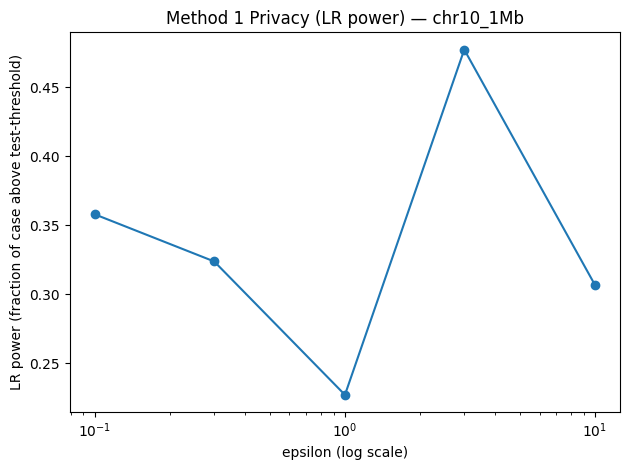

Saved: results/figures/method1/chr10_1Mb.privacy_lr_power.png


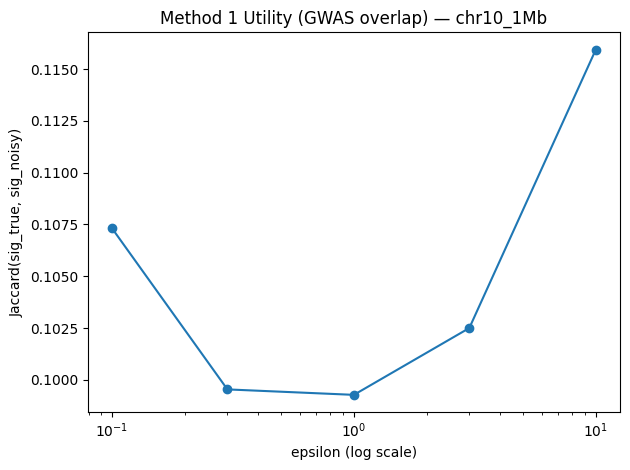

Saved: results/figures/method1/chr10_1Mb.utility_jaccard.png


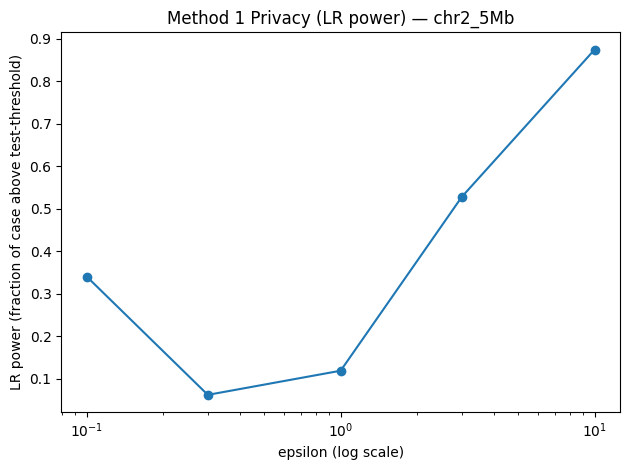

Saved: results/figures/method1/chr2_5Mb.privacy_lr_power.png


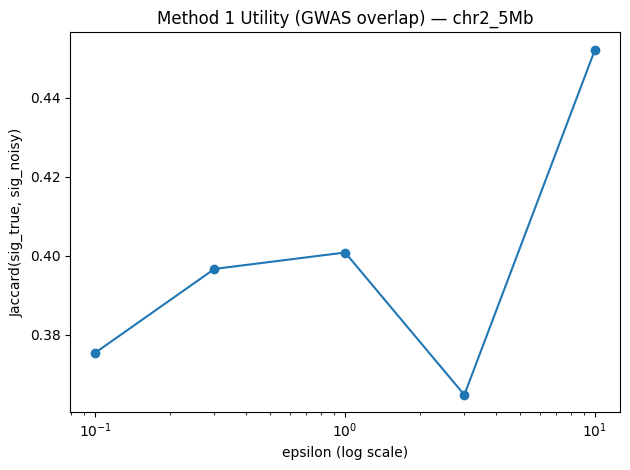

Saved: results/figures/method1/chr2_5Mb.utility_jaccard.png


In [12]:
# Save summary table
summary_csv = TABLE_DIR / "method1_summary.csv"
df.to_csv(summary_csv, index=False)
print("Saved summary table ->", summary_csv.relative_to(PROJECT_ROOT))

# Save a "pretty" table WITHOUT requiring tabulate
summary_md = TABLE_DIR / "method1_summary.md"
try:
    md = df.to_markdown(index=False)  # requires tabulate
    summary_md.write_text(md)
    print("Saved markdown table ->", summary_md.relative_to(PROJECT_ROOT))
except Exception:
    print("tabulate not installed; skipping markdown table.")

# -------------------------
# Plots: Privacy curve + Utility curve (per region)
# -------------------------
for region_tag in df["region"].unique():
    sub = df[df["region"] == region_tag].copy()

    # Privacy curve: LR power vs epsilon
    plt.figure()
    plt.plot(sub["eps"], sub["lr_power_case_above_threshold"], marker="o")
    plt.xscale("log")
    plt.xlabel("epsilon (log scale)")
    plt.ylabel("LR power (fraction of case above test-threshold)")
    plt.title(f"Method 1 Privacy (LR power) — {region_tag}")
    out = FIG_DIR / f"{region_tag}.privacy_lr_power.png"
    plt.tight_layout()
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out.relative_to(PROJECT_ROOT))

    # Utility curve: Jaccard vs epsilon
    plt.figure()
    plt.plot(sub["eps"], sub["jaccard"], marker="o")
    plt.xscale("log")
    plt.xlabel("epsilon (log scale)")
    plt.ylabel("Jaccard(sig_true, sig_noisy)")
    plt.title(f"Method 1 Utility (GWAS overlap) — {region_tag}")
    out = FIG_DIR / f"{region_tag}.utility_jaccard.png"
    plt.tight_layout()
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out.relative_to(PROJECT_ROOT))


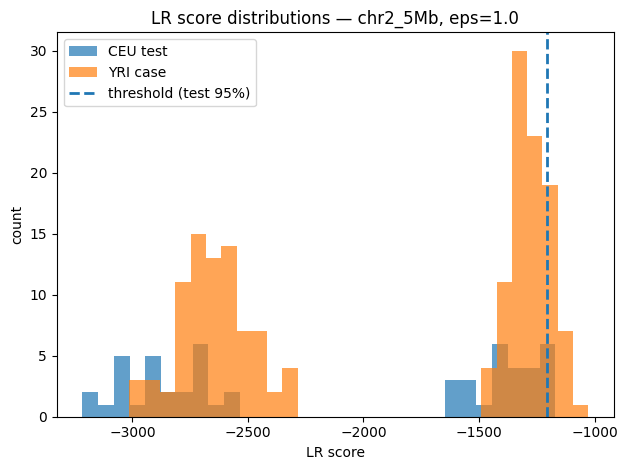

Saved: results/figures/method1/chr2_5Mb.lr_hist_eps_1p0.png


In [13]:
# Pick an epsilon to visualize distributions
EPS_TO_PLOT = EPS_LIST[2]  # e.g., 1.0
region_tag = "chr2_5Mb"  # change if you want

outdir = eps_dir(EPS_TO_PLOT)
noisy_path = outdir / f"{region_tag}.case_maf_noisy.npz"
z = np.load(noisy_path, allow_pickle=True)
maf_case_noisy = z["noisy_maf"]

b = baseline[region_tag]
G_ceu = b["G_ceu"]
G_yri = b["G_yri"]
maf_ctrl = b["maf_ctrl"]

cols_case = cohorts["case"]["indices_in_yri_matrix"]
cols_test = cohorts["test"]["indices_in_ceu_matrix"]

scores_case = lr_scores(G_yri, cols_case, p_case=maf_case_noisy, p_ctrl=maf_ctrl)
scores_test = lr_scores(G_ceu, cols_test, p_case=maf_case_noisy, p_ctrl=maf_ctrl)

thresh = float(np.quantile(scores_test, 1.0 - ALPHA_TEST_EXCEED))

plt.figure()
plt.hist(scores_test, bins=30, alpha=0.7, label="CEU test")
plt.hist(scores_case, bins=30, alpha=0.7, label="YRI case")
plt.axvline(thresh, linestyle="--", linewidth=2, label="threshold (test 95%)")
plt.xlabel("LR score")
plt.ylabel("count")
plt.title(f"LR score distributions — {region_tag}, eps={EPS_TO_PLOT}")
plt.legend()
out = FIG_DIR / f"{region_tag}.lr_hist_eps_{str(EPS_TO_PLOT).replace('.','p')}.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out.relative_to(PROJECT_ROOT))


In [15]:
print("=== Derived outputs check ===")
ok = True
for eps in EPS_LIST:
    outdir = eps_dir(eps)
    for region_tag in regions.keys():
        p = outdir / f"{region_tag}.case_maf_noisy.npz"
        if not p.exists():
            ok = False
            print(" missing:", p.relative_to(PROJECT_ROOT))
        else:
            print("present:", p.relative_to(PROJECT_ROOT))
print("FINAL:", "all good" if ok else " missing files")


=== Derived outputs check ===
present: data/derived/method1/eps_0p1/chr2_5Mb.case_maf_noisy.npz
present: data/derived/method1/eps_0p1/chr10_1Mb.case_maf_noisy.npz
present: data/derived/method1/eps_0p3/chr2_5Mb.case_maf_noisy.npz
present: data/derived/method1/eps_0p3/chr10_1Mb.case_maf_noisy.npz
present: data/derived/method1/eps_1p0/chr2_5Mb.case_maf_noisy.npz
present: data/derived/method1/eps_1p0/chr10_1Mb.case_maf_noisy.npz
present: data/derived/method1/eps_3p0/chr2_5Mb.case_maf_noisy.npz
present: data/derived/method1/eps_3p0/chr10_1Mb.case_maf_noisy.npz
present: data/derived/method1/eps_10p0/chr2_5Mb.case_maf_noisy.npz
present: data/derived/method1/eps_10p0/chr10_1Mb.case_maf_noisy.npz
FINAL: all good
